---


# Image Segmentation
* dataset: [Small object detection을 위한 이미지 데이터](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=data&dataSetSn=476)
* model : DeepLabV3Plus


---

## 1) Import library

In [2]:
import os
import json
import random
import argparse
from argparse import Namespace
import numpy as np
from xml.dom import minidom
import xml.etree.ElementTree as ET
import glob
from glob import glob

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.cuda.amp import autocast, GradScaler

import utils
import network
from datasets import CustomSegmentation
from datasets.voc import voc_cmap, download_extract
from network.utils import IntermediateLayerGetter
from network._deeplab import DeepLabHead, DeepLabHeadV3Plus, DeepLabV3, ASPPConv, ASPPPooling
from network.backbone import resnet
from utils import ext_transforms as et
from utils.scheduler import PolyLR
from utils.visualizer import Visualizer
from metrics import StreamSegMetrics

torch.cuda.empty_cache()

## 2) load custom data

### convert json to xml

In [3]:
def json_to_pascal_voc(json_file, output_dir):
    class_mapping = {
        "비행기": 0,
        "헬리콥터": 1,
        "전투기": 2,
        "패러글라이딩": 3,
        "드론": 4
    }

    with open(json_file, encoding='utf-8') as f:
        data = json.load(f)

    for image_info in data['images']:
        image_id = image_info['id']
        file_name = image_info['file_name']
        width = image_info['width']
        height = image_info['height']

        # Create XML structure
        annotation = ET.Element("annotation")

        folder = ET.SubElement(annotation, "folder").text = "VOC2007"
        filename = ET.SubElement(annotation, "filename").text = file_name

        size = ET.SubElement(annotation, "size")
        ET.SubElement(size, "width").text = str(width)
        ET.SubElement(size, "height").text = str(height)
        ET.SubElement(size, "depth").text = "3"

        segmented = ET.SubElement(annotation, "segmented").text = "1"

        for annotation_info in data['annotations']:
            if annotation_info['image_id'] == image_id:
                obj = ET.SubElement(annotation, "object")
                category_id = annotation_info['category_id']

                # Find the category name
                category_name = ""
                for category in data['categories']:
                    if category['class_id'] == category_id:
                        category_name = category['class_name']
                        break

                class_id = class_mapping.get(category_name, -1)

                ET.SubElement(obj, "name").text = str(class_id)
                ET.SubElement(obj, "pose").text = "Unspecified"
                ET.SubElement(obj, "truncated").text = "0"
                ET.SubElement(obj, "difficult").text = "0"

                bndbox = ET.SubElement(obj, "bndbox")
                bbox = annotation_info['bbox']
                ET.SubElement(bndbox, "xmin").text = str(int(bbox[0]))
                ET.SubElement(bndbox, "ymin").text = str(int(bbox[1]))
                ET.SubElement(bndbox, "xmax").text = str(int(bbox[0] + bbox[2]))
                ET.SubElement(bndbox, "ymax").text = str(int(bbox[1] + bbox[3]))

                # Add segmentation points
                seg = ET.SubElement(obj, "segmentation")
                for point in annotation_info['segmentation']:
                    point_elem = ET.SubElement(seg, "point")
                    ET.SubElement(point_elem, "x").text = str(point['x'])
                    ET.SubElement(point_elem, "y").text = str(point['y'])

        # Write to XML file
        tree = ET.ElementTree(annotation)
        xml_str = minidom.parseString(ET.tostring(annotation)).toprettyxml(indent="    ")
        output_file = os.path.join(output_dir, f"{image_id}.xml")
        with open(output_file, "w") as f:
            f.write(xml_str)

In [4]:
input_dir='./test_example/json'
output_dir='./test_example/xml'

os.makedirs(output_dir, exist_ok=True)
json_files = glob(os.path.join(input_dir, "*.json"))

for json_file in json_files:
    json_to_pascal_voc(json_file, output_dir)

### generate mask

In [5]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        polygon = []
        for pt in obj.find('segmentation').findall('point'):
            x = int(float(pt.find('x').text))
            y = int(float(pt.find('y').text))
            polygon.append((x, y))
        objects.append((name, polygon))

    return objects

def create_mask(image_size, objects):
    mask = Image.new('RGB', image_size, (0, 0, 0))
    draw = ImageDraw.Draw(mask)

    for obj in objects:
        class_name, polygon = obj
        color = class_color_map.get(class_name, (0, 0, 0))
        print(f"Class: {class_name}, Color: {color}")
        draw.polygon(polygon, outline=color, fill=color)

    return mask

### example

Class: 0, Color: (255, 0, 0)
Saved mask to /kaggle/working/segmentation-dataset/test_example/mask/913281_597.png


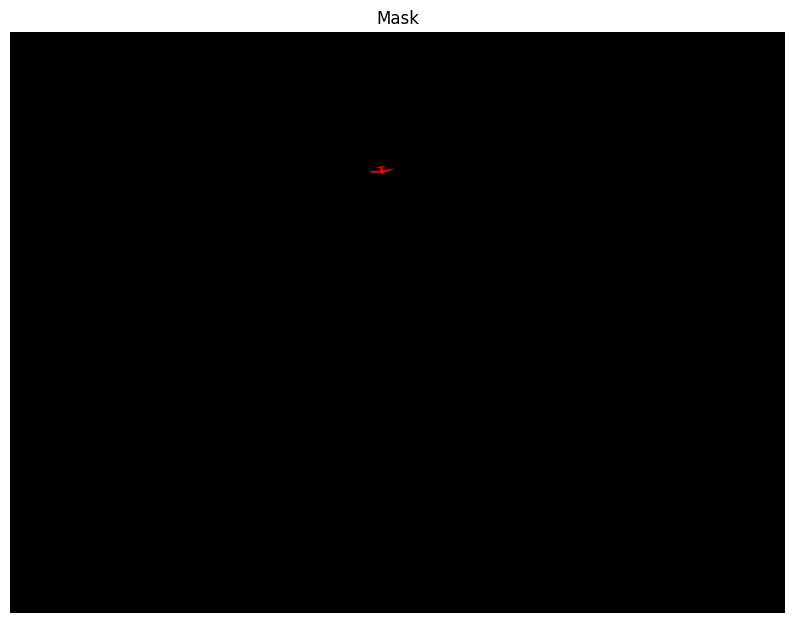

Mask image generation completed.


In [6]:
# file path
xml_dir = "./test_example/xml"
image_dir = "./test_example/images"
mask_dir = "./test_example/mask"

# Match class names to colors
class_color_map = {
    "0": (255, 0, 0),    # red
    "1": (0, 255, 0),    # green
    "2": (0, 0, 255),    # blue
    "3": (255, 255, 0),  # yellow
    "4": (0, 255, 255)   # cyan
}

if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

# Generate mask image
for xml_file in os.listdir(xml_dir):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(xml_dir, xml_file)
        image_file = xml_file.replace(".xml", ".jpg")
        image_path = os.path.join(image_dir, image_file)

        if os.path.exists(image_path):
            image = Image.open(image_path)
            image_size = image.size

            objects = parse_xml(xml_path)

            mask = create_mask(image_size, objects)

            mask_file = xml_file.replace(".xml", ".png")
            mask_path = os.path.join(mask_dir, mask_file)
            mask.save(mask_path)
            print(f"Saved mask to {mask_path}")

           # Display using matplotlib
            plt.figure(figsize=(10, 10))
            plt.imshow(mask)
            plt.axis('off')
            plt.title("Mask")
            plt.show()


print("Mask image generation completed.")

### define function for custom data

In [7]:
class CustomSegmentation(data.Dataset):
    colormap = {
        0: (0, 0, 0),       # Background
        1: (255, 0, 0),     # Class 1
        2: (0, 255, 0),     # Class 2
        3: (0, 0, 255),     # Class 3
        4: (255, 255, 0),   # Class 4
        5: (0, 255, 255)    # Class 5
    }

    def __init__(self, root, image_set='train', transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.image_set = image_set

        image_dir = os.path.join(self.root, 'JPEGImages')
        mask_dir = os.path.join(self.root, 'SegmentationClass')
        splits_dir = os.path.join(self.root, 'ImageSets/Segmentation')
        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        if not os.path.exists(split_f):
            raise ValueError('Specified image_set does not exist.')

        with open(split_f, "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.masks = [os.path.join(mask_dir, x + ".png") for x in file_names]
        assert (len(self.images) == len(self.masks))

    @classmethod
    def decode_target(cls, mask):
        mask = mask.squeeze()
        color_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for label, color in cls.colormap.items():
            color_image[mask == label] = color
        return color_image

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        mask = Image.open(self.masks[index]).convert('RGB')
        mask = self.rgb_to_mask(mask)

        if self.transform:
            img, mask = self.transform(img, mask)
        return img, mask

    def __len__(self):
        return len(self.images)

    def rgb_to_mask(self, mask_rgb):
        mask_rgb = np.array(mask_rgb)
        mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.int32)

        for label, rgb in self.colormap.items():
            matches = (mask_rgb == rgb).all(axis=2)
            mask[matches] = label

        unmapped_pixels = ~np.isin(mask_rgb, list(self.colormap.values())).all(axis=2)
        if np.any(unmapped_pixels):
            print("Warning: Found unmapped pixels in mask.")

        return mask

## 3) set data & config for model

In [8]:
class Config:
    data_root = './VOCdevkit/VOC2007'
    dataset = 'custom'
    num_classes = 6
    model = "custom_model"
    separable_conv = False
    output_stride = 16
    batch_size = 8
    val_batch_size =8
    crop_size = 513
    total_itrs = 14000
    lr = 0.01
    lr_policy = 'step'
    gpu_id = '0,1'
    save_val_results = True
    enable_vis = False
    val_interval=300
    test_only=False
    weight_decay=1e-4
    continue_training=True
    ckpt='./checkpoints/pretrain_deeplabv3plus_resnet101_custom_os16.pth'
    crop_val=True

opts = Config()

### data augmentation

In [9]:
def get_dataset(opts):
    train_transform = et.ExtCompose([
        et.ExtResize(size=opts.crop_size),
        et.ExtRandomScale((0.8, 1.5)),
        et.ExtRandomCrop(size=(opts.crop_size, opts.crop_size), pad_if_needed=True),
        et.ExtRandomHorizontalFlip(),
        et.ExtRandomVerticalFlip(p=0.3),
        et.ExtColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        et.ExtRandomRotation(degrees=10),
        et.ExtToTensor(),
        et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    ])
    val_transform = et.ExtCompose([
        et.ExtResize(size=opts.crop_size),
        et.ExtToTensor(),
        et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    ])

    # Load datasets
    train_dst = CustomSegmentation(root=opts.data_root, image_set='train', transform=train_transform)
    val_dst = CustomSegmentation(root=opts.data_root, image_set='val', transform=val_transform)
    train_dst_no_transform = CustomSegmentation(root=opts.data_root, image_set='train', transform=None)


    return train_dst, val_dst, train_transform, train_dst_no_transform

train_dst, val_dst, train_transform, train_dst_no_transform = get_dataset(opts)

In [10]:
train_loader = DataLoader(train_dst, batch_size=opts.batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dst, batch_size=opts.val_batch_size, shuffle=False, num_workers=0)

print("Dataset: %s, Train set: %d, Val set: %d" %
          (opts.dataset, len(train_dst), len(val_dst)))

Dataset: custom, Train set: 500, Val set: 100


### vizualize augmentation data

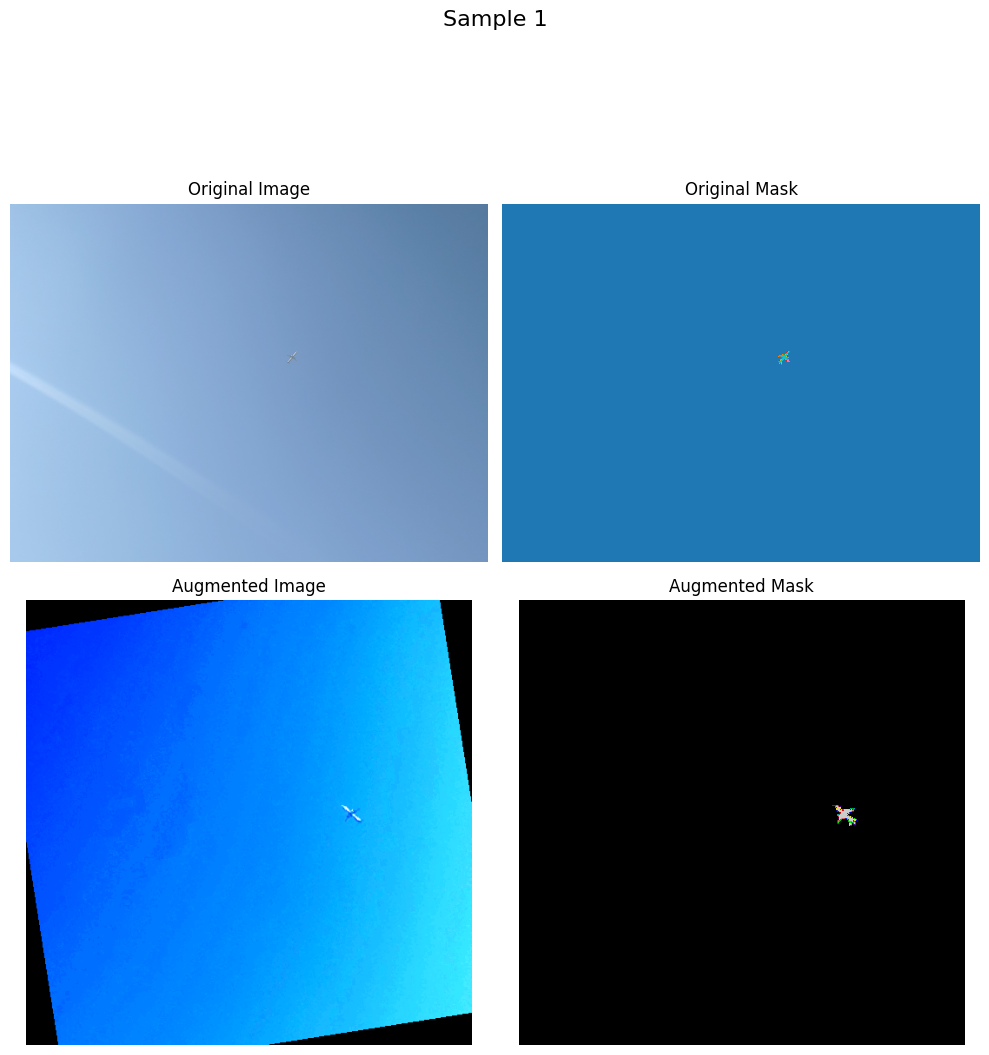

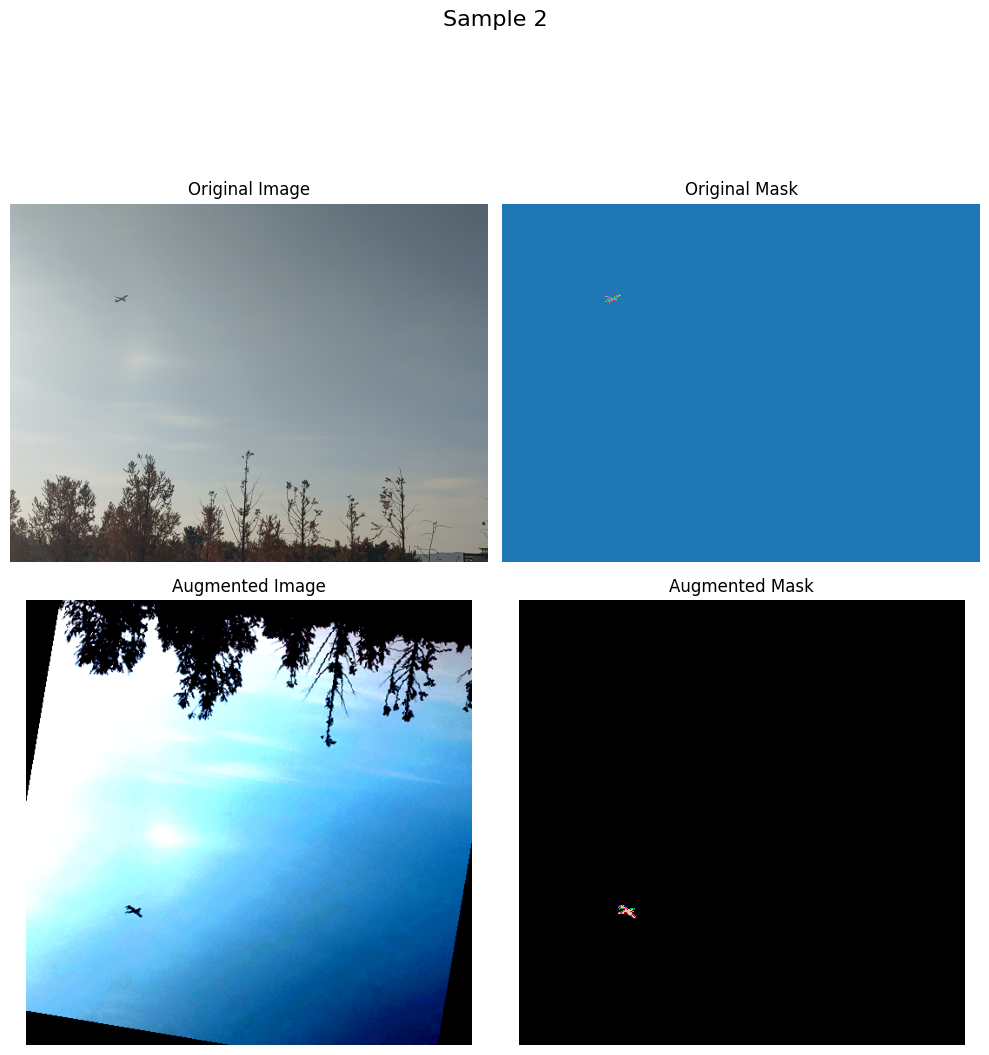

In [11]:
def visualize_dataset_with_augmentation(dataset, transform, num_samples=3):
    from torchvision.transforms.functional import to_pil_image
    import numpy as np
    import matplotlib.pyplot as plt

    for idx in range(num_samples):
        original_image, original_mask = dataset[idx]

        if isinstance(original_image, torch.Tensor):
            original_image = to_pil_image(original_image)

        if isinstance(original_mask, torch.Tensor):
            original_mask = original_mask.squeeze(0).numpy()

        augmented_image, augmented_mask = transform(original_image, original_mask)

        if isinstance(augmented_image, torch.Tensor):
            augmented_image = augmented_image.permute(1, 2, 0).numpy()
        if isinstance(augmented_mask, torch.Tensor):
            augmented_mask = augmented_mask.squeeze(0).numpy()

        if augmented_image.dtype == 'float32':  
            augmented_image = np.clip(augmented_image, 0, 1)
        elif augmented_image.dtype == 'uint8':  
            augmented_image = np.clip(augmented_image, 0, 255)


        augmented_mask = np.where(augmented_mask == 255, 0, augmented_mask)

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        fig.suptitle(f"Sample {idx + 1}", fontsize=16, y=1.05)

        axs[0, 0].imshow(np.array(original_image))
        axs[0, 0].set_title("Original Image", fontsize=12)
        axs[0, 0].axis('off')

        axs[0, 1].imshow(original_mask, cmap="tab10")
        axs[0, 1].set_title("Original Mask", fontsize=12)
        axs[0, 1].axis('off')

        axs[1, 0].imshow(augmented_image)
        axs[1, 0].set_title("Augmented Image", fontsize=12)
        axs[1, 0].axis('off')

        axs[1, 1].imshow(augmented_mask, cmap="nipy_spectral")
        axs[1, 1].set_title("Augmented Mask", fontsize=12)
        axs[1, 1].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

visualize_dataset_with_augmentation(train_dst_no_transform, train_transform, num_samples=2)

## 4) load model architecture

In [12]:
class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)))

        rate1, rate2, rate3 = tuple(atrous_rates)
        modules.append(ASPPConv(in_channels, out_channels, rate1))
        modules.append(ASPPConv(in_channels, out_channels, rate2))
        modules.append(ASPPConv(in_channels, out_channels, rate3))
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),)

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

class DeepLabHeadV3Plus(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes, aspp_dilate=[12, 24, 36]):
        super(DeepLabHeadV3Plus, self).__init__()
        self.project = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )

        self.aspp = ASPP(in_channels, aspp_dilate)

        self.classifier = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, 1)
        )
        self._init_weight()

    def forward(self, feature):
        low_level_feature = self.project( feature['low_level'] )
        output_feature = self.aspp(feature['out'])
        output_feature = F.interpolate(output_feature, size=low_level_feature.shape[2:], mode='bilinear', align_corners=False)
        return self.classifier( torch.cat( [ low_level_feature, output_feature ], dim=1 ) )

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [13]:
def _segm_resnet(name, backbone_name, num_classes, output_stride, pretrained_backbone):

    if output_stride==8:
        replace_stride_with_dilation=[False, True, True]
        aspp_dilate = [12, 24, 36]
    else:
        replace_stride_with_dilation=[False, False, True]
        aspp_dilate = [6, 12, 18]

    backbone = resnet.__dict__[backbone_name](
        pretrained=pretrained_backbone,
        replace_stride_with_dilation=replace_stride_with_dilation)

    inplanes = 2048
    low_level_planes = 256

    return_layers = {'layer4': 'out', 'layer1': 'low_level'}
    classifier = DeepLabHeadV3Plus(inplanes, low_level_planes, num_classes, aspp_dilate)
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    model = DeepLabV3(backbone, classifier)
    return model

def _load_model(arch_type, backbone, num_classes, output_stride, pretrained_backbone):

    if backbone.startswith('resnet'):
        model = _segm_resnet(arch_type, backbone, num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)
    else:
        raise NotImplementedError
    return model

def deeplabv3plus_resnet101(num_classes=6, output_stride=8, pretrained_backbone=True):
    return _load_model('deeplabv3plus', 'resnet101', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)

### Initialize custom model

In [14]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
custom_model = deeplabv3plus_resnet101(num_classes=opts.num_classes, output_stride=opts.output_stride, pretrained_backbone=True).to(device)
print("Custom Model Structure:")
print(custom_model)

Custom Model Structure:
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)


### define function for training and validation metrics visualization

In [16]:
def interpolate_values(reference_list, target_list):
    if not target_list:
        target_list = [0]

    if len(target_list) < len(reference_list):
        extended_values = target_list + [target_list[-1]] * (len(reference_list) - len(target_list))
    else:
        extended_values = target_list[:len(reference_list)]

    extended_values = [0 if (np.isnan(x) or x is None) else x for x in extended_values]
    return extended_values


def plot_training_results(train_losses, val_losses, val_class_ious):
    val_losses_interp = interpolate_values(train_losses, val_losses)
    val_class_ious_interp = {class_id: interpolate_values(train_losses, ious)
                             for class_id, ious in val_class_ious.items()}

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(train_losses, label="Train Loss", color="blue")
    axes[0].plot(val_losses_interp, label="Val Loss", color="orange", linestyle="dashed")
    axes[0].set_title("Loss Over Iterations", fontsize=16)
    axes[0].set_xlabel("Iterations", fontsize=14)
    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].grid(True)

    for class_id, ious in val_class_ious_interp.items():
        axes[1].plot(ious, label=f"Class {class_id}", linestyle="dashed")
    axes[1].set_title("Class-wise IoU Over Iterations", fontsize=16)
    axes[1].set_xlabel("Iterations", fontsize=14)
    axes[1].set_ylabel("Class-wise IoU", fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


## 5) Train model

In [17]:
def train(opts, model, train_loader, val_loader, optimizer, scheduler, criterion, metrics, vis=None):
    train_losses, val_losses = [], []
    train_overall_accs, val_overall_accs = [], []
    train_mean_ious, val_mean_ious = [], []
    train_class_ious = {i: [] for i in range(opts.num_classes)}
    val_class_ious = {i: [] for i in range(opts.num_classes)}


    model = model.to(device)
    utils.set_bn_momentum(model.backbone, momentum=0.01)

    def save_ckpt(path):
        torch.save({
            "cur_itrs": cur_itrs,
            "model_state": model.module.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "best_score": best_score,
        }, path)
        print("Model saved as %s" % path)

    utils.mkdir('checkpoints')
    # Restore
    best_score = 0.0
    cur_itrs = 0
    cur_epochs = 0

    if opts.ckpt is not None and os.path.isfile(opts.ckpt):
        checkpoint = torch.load(opts.ckpt, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint["model_state"])
        model = nn.DataParallel(model) #
        model.to(device)
        if opts.continue_training:
            optimizer.load_state_dict(checkpoint["optimizer_state"])
            scheduler.load_state_dict(checkpoint["scheduler_state"])
            cur_itrs = checkpoint["cur_itrs"]
            best_score = checkpoint['best_score']
            print("Training state restored from %s" % opts.ckpt)
        print("Model restored from %s" % opts.ckpt)
    else:
        print("[!] Retrain")
        model = nn.DataParallel(model) #
        model.to(device)

    vis_sample_id = np.random.randint(0, len(val_loader), opts.vis_num_samples,
                                      np.int32) if opts.enable_vis else None
    denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    interval_loss = 0
    while cur_itrs < opts.total_itrs:
        #print('train') ###
        model.train()
        cur_epochs += 1
        for (images, labels) in train_loader:
            cur_itrs += 1

            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            np_loss = loss.detach().cpu().numpy()
            interval_loss += np_loss
            train_losses.append(np_loss)


            if vis is not None:
                vis.vis_scalar('Loss', cur_itrs, np_loss)

            if (cur_itrs) % 10 == 0:
                interval_loss = interval_loss / 10
                print("Epoch %d, Itrs %d/%d, Loss=%f" %
                      (cur_epochs, cur_itrs, opts.total_itrs, interval_loss))
                interval_loss = 0.0

            if (cur_itrs) % opts.val_interval == 0:
                save_ckpt('checkpoints/latest_%s_%s_os%d.pth' %
                          (opts.model, opts.dataset, opts.output_stride))
                print("validation...")

                model.eval()
                val_score, ret_samples = validate(opts=opts, model=model, loader=val_loader, device=device, metrics=metrics,ret_samples_ids=vis_sample_id)
                print(metrics.to_str(val_score))

                val_losses.append(val_score.get("Loss", 0))

                val_overall_accs.append(val_score["Overall Acc"])
                val_mean_ious.append(val_score["Mean IoU"])
                for class_id, iou in val_score["Class IoU"].items():
                    val_class_ious[class_id].append(iou)

                if len(val_losses) > 0:
                    last_val_loss = val_losses[-1]
                else:
                    last_val_loss = train_losses[-1]
                val_losses.extend([last_val_loss] * (len(train_losses) - len(val_losses)))

                if val_score['Mean IoU'] > best_score:
                    best_score = val_score['Mean IoU']
                    save_ckpt('checkpoints/best_%s_%s_os%d.pth' %
                              (opts.model, opts.dataset, opts.output_stride))

                if vis is not None:
                    vis.vis_scalar("[Val] Overall Acc", cur_itrs, val_score['Overall Acc'])
                    vis.vis_scalar("[Val] Mean IoU", cur_itrs, val_score['Mean IoU'])
                    vis.vis_table("[Val] Class IoU", val_score['Class IoU'])

                    for k, (img, target, lbl) in enumerate(ret_samples):
                        img = (denorm(img) * 255).astype(np.uint8)
                        target = train_dst.decode_target(target).transpose(2, 0, 1).astype(np.uint8)
                        lbl = train_dst.decode_target(lbl).transpose(2, 0, 1).astype(np.uint8)
                        concat_img = np.concatenate((img, target, lbl), axis=2)
                        vis.vis_image('Sample %d' % k, concat_img)
                model.train()

            if scheduler.last_epoch >= scheduler.max_iters:
                scheduler.last_epoch = scheduler.max_iters - 1

            scheduler.step()

            if cur_itrs >= opts.total_itrs:
                plot_training_results(train_losses, val_losses, val_class_ious)
                return

In [18]:
def validate(opts, model, loader, device, metrics, ret_samples_ids=None):

    import matplotlib
    metrics.reset()
    total_loss = 0.0
    ret_samples = []
    result_dir = opts.result_dir if hasattr(opts, 'result_dir') else 'results'

    if opts.save_val_results:
        if not os.path.exists('results'):
            os.mkdir('results')
        denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
        img_id = 0

    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader)):

            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            score = metrics.get_results()
            score['Loss'] = total_loss / len(loader)

            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets = labels.cpu().numpy()

            metrics.update(targets, preds)
            if ret_samples_ids is not None and i in ret_samples_ids:
                ret_samples.append(
                    (images[0].detach().cpu().numpy(), targets[0], preds[0]))

            if opts.save_val_results:
                for i in range(len(images)):
                    image = images[i].detach().cpu().numpy()
                    target = targets[i]
                    pred = preds[i]

                    image = (denorm(image) * 255).transpose(1, 2, 0).astype(np.uint8)
                    target = loader.dataset.decode_target(target).astype(np.uint8)
                    pred = loader.dataset.decode_target(pred).astype(np.uint8)

                    Image.fromarray(image).save('results/%d_image.png' % img_id)
                    Image.fromarray(target).save('results/%d_target.png' % img_id)
                    Image.fromarray(pred).save('results/%d_pred.png' % img_id)

                    fig = plt.figure()
                    plt.imshow(image)
                    plt.axis('off')
                    plt.imshow(pred, alpha=0.7)
                    ax = plt.gca()
                    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
                    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
                    plt.savefig('results/%d_overlay.png' % img_id, bbox_inches='tight', pad_inches=0)
                    plt.close()
                    img_id += 1

        score = metrics.get_results()
        score['Loss'] = total_loss / len(loader)
    return score, ret_samples

### set training configuration

In [19]:
metrics = StreamSegMetrics(opts.num_classes)
optimizer = torch.optim.SGD([
    {'params': custom_model.backbone.parameters(), 'lr': 0.1 * opts.lr},
    {'params': custom_model.classifier.parameters(), 'lr': opts.lr},
    ], lr=opts.lr, weight_decay=opts.weight_decay)
scheduler = PolyLR(optimizer, opts.total_itrs, power=0.9)

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0, size_average=True, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.size_average = size_average

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(
            inputs, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        if self.size_average:
            return focal_loss.mean()
        else:
            return focal_loss.sum()

criterion= FocalLoss(alpha=0.25, gamma=2.0)

### train & see loss and performance

/tmp/ipykernel_3541/242982313.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(opts.ckpt, map_location=torch.device('cpu'))


Training state restored from /kaggle/working/segmentation-dataset/checkpoints/pretrain_deeplabv3plus_resnet101_custom_os16.pth
Model restored from /kaggle/working/segmentation-dataset/checkpoints/pretrain_deeplabv3plus_resnet101_custom_os16.pth


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1, Itrs 13410/14000, Loss=0.000613
Epoch 1, Itrs 13420/14000, Loss=0.000375
Epoch 1, Itrs 13430/14000, Loss=0.000469
Epoch 1, Itrs 13440/14000, Loss=0.000495
Epoch 1, Itrs 13450/14000, Loss=0.000638
Epoch 1, Itrs 13460/14000, Loss=0.000545
Epoch 2, Itrs 13470/14000, Loss=0.000499
Epoch 2, Itrs 13480/14000, Loss=0.000589
Epoch 2, Itrs 13490/14000, Loss=0.000487
Epoch 2, Itrs 13500/14000, Loss=0.000485
Model saved as checkpoints/latest_custom_model_custom_os16.pth
validation...


0it [00:00, ?it/s]/kaggle/working/Image_segmentation/metrics/stream_metrics.py:65: RuntimeWarning: invalid value encountered in scalar divide
  acc = np.diag(hist).sum() / hist.sum()
/kaggle/working/Image_segmentation/metrics/stream_metrics.py:66: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/kaggle/working/Image_segmentation/metrics/stream_metrics.py:67: RuntimeWarning: Mean of empty slice
  acc_cls = np.nanmean(acc_cls)
/kaggle/working/Image_segmentation/metrics/stream_metrics.py:68: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
/kaggle/working/Image_segmentation/metrics/stream_metrics.py:69: RuntimeWarning: Mean of empty slice
  mean_iu = np.nanmean(iu)
/kaggle/working/Image_segmentation/metrics/stream_metrics.py:70: RuntimeWarning: invalid value encountered in divide
  freq = hist.sum(axis=1) / hist.sum()
13it [03:15, 15.08s/it]



Overall Acc: 0.999389
Mean Acc: 0.665253
FreqW Acc: 0.999063
Mean IoU: 0.453004
Loss: 0.000228

Epoch 2, Itrs 13510/14000, Loss=0.001041
Epoch 2, Itrs 13520/14000, Loss=0.000456
Epoch 3, Itrs 13530/14000, Loss=0.000538
Epoch 3, Itrs 13540/14000, Loss=0.000884
Epoch 3, Itrs 13550/14000, Loss=0.000515
Epoch 3, Itrs 13560/14000, Loss=0.000450
Epoch 3, Itrs 13570/14000, Loss=0.000283
Epoch 3, Itrs 13580/14000, Loss=0.000344
Epoch 4, Itrs 13590/14000, Loss=0.000610
Epoch 4, Itrs 13600/14000, Loss=0.000273
Epoch 4, Itrs 13610/14000, Loss=0.000731
Epoch 4, Itrs 13620/14000, Loss=0.000457
Epoch 4, Itrs 13630/14000, Loss=0.000362
Epoch 4, Itrs 13640/14000, Loss=0.000436
Epoch 5, Itrs 13650/14000, Loss=0.000549
Epoch 5, Itrs 13660/14000, Loss=0.000494
Epoch 5, Itrs 13670/14000, Loss=0.000382
Epoch 5, Itrs 13680/14000, Loss=0.000505
Epoch 5, Itrs 13690/14000, Loss=0.000463
Epoch 5, Itrs 13700/14000, Loss=0.000469
Epoch 5, Itrs 13710/14000, Loss=0.000448
Epoch 6, Itrs 13720/14000, Loss=0.000380
E

13it [03:13, 14.87s/it]



Overall Acc: 0.999306
Mean Acc: 0.709723
FreqW Acc: 0.998975
Mean IoU: 0.453565
Loss: 0.000245

Epoch 7, Itrs 13810/14000, Loss=0.000349
Epoch 7, Itrs 13820/14000, Loss=0.000349
Epoch 7, Itrs 13830/14000, Loss=0.000469
Epoch 8, Itrs 13840/14000, Loss=0.000467
Epoch 8, Itrs 13850/14000, Loss=0.000477
Epoch 8, Itrs 13860/14000, Loss=0.000384
Epoch 8, Itrs 13870/14000, Loss=0.000694
Epoch 8, Itrs 13880/14000, Loss=0.000353
Epoch 8, Itrs 13890/14000, Loss=0.000335
Epoch 9, Itrs 13900/14000, Loss=0.000306
Epoch 9, Itrs 13910/14000, Loss=0.000377
Epoch 9, Itrs 13920/14000, Loss=0.000387
Epoch 9, Itrs 13930/14000, Loss=0.000551
Epoch 9, Itrs 13940/14000, Loss=0.000424
Epoch 9, Itrs 13950/14000, Loss=0.000496
Epoch 10, Itrs 13960/14000, Loss=0.000531
Epoch 10, Itrs 13970/14000, Loss=0.000346
Epoch 10, Itrs 13980/14000, Loss=0.000647
Epoch 10, Itrs 13990/14000, Loss=0.000469
Epoch 10, Itrs 14000/14000, Loss=0.000302


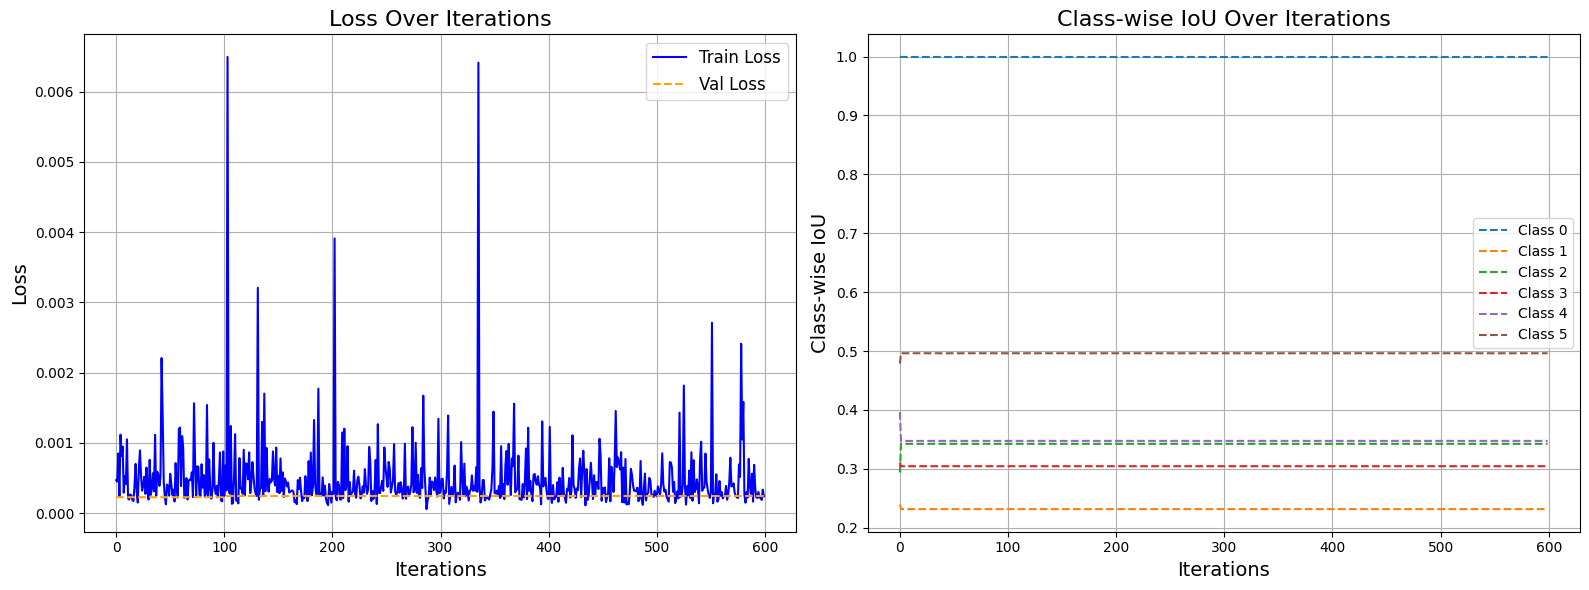

In [21]:
train(opts=opts,
    model=custom_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    metrics=metrics)

## 6) Prediction

In [22]:
def predict(opts):
    num_classes = 6
    decode_fn = CustomSegmentation.decode_target

    os.environ['CUDA_VISIBLE_DEVICES'] = opts.gpu_id
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    image_files = []
    if os.path.isdir(opts.input):
        for ext in ['png', 'jpeg', 'jpg', 'JPEG']:
            files = glob(os.path.join(opts.input, f'**/*.{ext}'), recursive=True)
            if len(files) > 0:
                image_files.extend(files)
    elif os.path.isfile(opts.input):
        image_files.append(opts.input)
    else:
        raise FileNotFoundError(f"Input path {opts.input} does not exist.")

    model = deeplabv3plus_resnet101(num_classes=opts.num_classes, output_stride=opts.output_stride, pretrained_backbone=True).to(device)
    if opts.separable_conv and 'plus' in opts.model:
        network.convert_to_separable_conv(model.classifier)
    utils.set_bn_momentum(model.backbone, momentum=0.01)

    if opts.ckpt is not None and os.path.isfile(opts.ckpt):
        checkpoint = torch.load(opts.ckpt, map_location=torch.device('cpu'))
        state_dict = checkpoint["model_state"]

        filtered_state_dict = {
            k: v for k, v in state_dict.items()
            if k in model.state_dict() and state_dict[k].shape == model.state_dict()[k].shape
        }

        missing_keys, unexpected_keys = model.load_state_dict(filtered_state_dict, strict=False)
        print(f"Model resumed from checkpoint: {opts.ckpt}")

        if missing_keys:
            print(f"Missing keys: {missing_keys}")
        if unexpected_keys:
            print(f"Unexpected keys: {unexpected_keys}")

        del checkpoint
    else:
        print("[!] No checkpoint found. Using initialized model weights.")

    model = nn.DataParallel(model)
    model.to(device)
    model.eval()

    if opts.crop_val:
        transform = T.Compose([
            T.Resize(opts.crop_size),
            T.CenterCrop(opts.crop_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])
    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    if opts.save_val_results_to is not None:
        os.makedirs(opts.save_val_results_to, exist_ok=True)

    with torch.no_grad():
        for img_path in tqdm(image_files):
            ext = os.path.basename(img_path).split('.')[-1]
            img_name = os.path.basename(img_path)[:-len(ext) - 1]

            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)

            pred = model(img_tensor).max(1)[1].cpu().numpy()[0]

            colorized_preds = decode_fn(pred).astype('uint8')
            colorized_preds = Image.fromarray(colorized_preds)

            # Plot original image, mask image, and prediction image
            fig, axes = plt.subplots(1, 3, figsize=(20, 10))
            axes[0].imshow(img)
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            # Mask image (if exists)
            if opts.mask_dir:
                mask_path = os.path.join(opts.mask_dir, img_name + '.png')
                if os.path.exists(mask_path):
                    mask = Image.open(mask_path).convert('RGB')
                    axes[1].imshow(mask)
                    axes[1].set_title('Mask Image')
                else:
                    axes[1].imshow(np.zeros_like(img))
                    axes[1].set_title('No Mask Found')
            else:
                axes[1].imshow(np.zeros_like(img))
                axes[1].set_title('No Mask Found')
            axes[1].axis('off')

            axes[2].imshow(colorized_preds)
            axes[2].set_title('Prediction Image')
            axes[2].axis('off')

            plt.show()

            if opts.save_val_results_to:
                colorized_preds.save(os.path.join(opts.save_val_results_to, img_name+'.png'))


Device: cuda


/tmp/ipykernel_3541/3330932032.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(opts.ckpt, map_location=torch.device('cpu'))


Model resumed from checkpoint: /kaggle/working/Image_segmentation/checkpoints/latest_custom_model_custom_os16.pth


  0%|          | 0/1 [00:00<?, ?it/s]

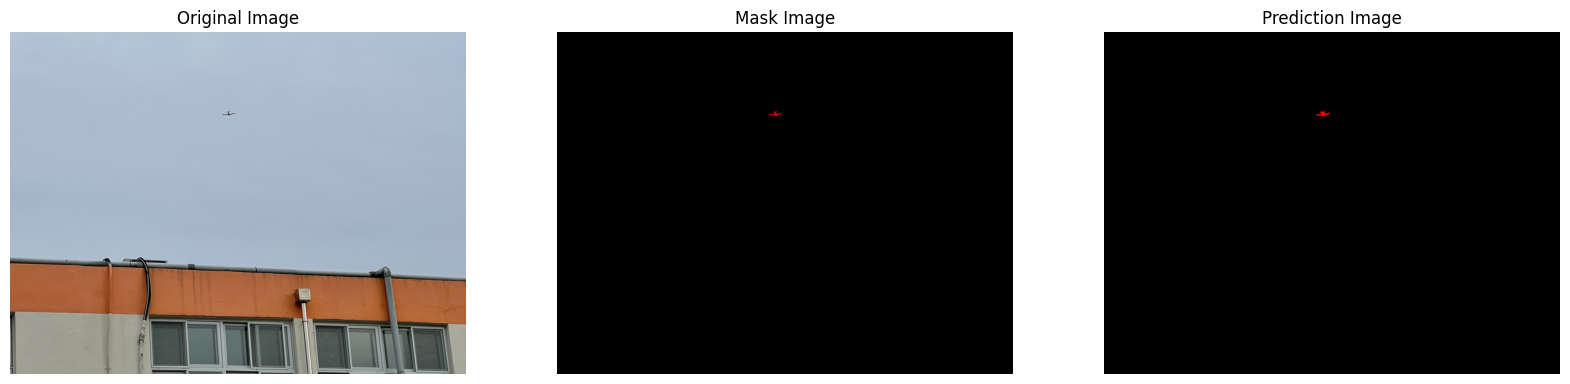

100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


In [23]:
class Config:
    input = "./test_example/images"  # 쉼표 제거
    mask_dir = "./test_example/mask"  # 쉼표 제거
    dataset = "custom"  # 쉼표 제거
    num_classes = 6
    separable_conv = False
    output_stride = 16
    save_val_results_to = "./test_results"
    crop_val = False
    crop_size = 513
    ckpt = "./checkpoints/latest_custom_model_custom_os16.pth"
    gpu_id = "0"

opts2 = Config()
predict(opts2)


## 7) Model Evaluation

In [24]:
def evaluate_model(model, dataloader, device, ckpt_path=None):
    opts.num_classes
    metrics = StreamSegMetrics(opts.num_classes)
    metrics.reset()

    if ckpt_path is not None:
        checkpoint = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        print(f"Pretrained weights loaded from {ckpt_path}")

    model.eval()
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(dataloader), desc="Evaluating"):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets = labels.cpu().numpy()

            metrics.update(targets, preds)

    score = metrics.get_results()

    formatted_score = {
        "Overall Acc": round(score["Overall Acc"], 6),
        "Mean Acc": round(score["Mean Acc"], 6),
        "FreqW Acc": round(score["FreqW Acc"], 6),
        "Mean IoU": round(score["Mean IoU"], 6),
        "Class IoU": {k: round(v, 6) for k, v in score["Class IoU"].items()}
    }

    return formatted_score

### evaluate testset

In [25]:
test_transform = et.ExtCompose([
    et.ExtResize(opts.crop_size),
    et.ExtCenterCrop(opts.crop_size),
    et.ExtToTensor(),
    et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
])
test_dst = CustomSegmentation(root=opts.data_root,image_set='test', transform=test_transform)

test_loader = data.DataLoader(test_dst, batch_size=opts.val_batch_size, shuffle=True, num_workers=0)

evaluate_model(model=custom_model, dataloader=test_loader, device=device, ckpt_path='./checkpoints/latest_custom_model_custom_os16.pth')

/tmp/ipykernel_3541/2612922501.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


Pretrained weights loaded from /kaggle/working/Image_segmentation/checkpoints/latest_custom_model_custom_os16.pth


Evaluating: 13it [02:22, 10.94s/it]


{'Overall Acc': 0.999289,
 'Mean Acc': 0.721119,
 'FreqW Acc': 0.998921,
 'Mean IoU': 0.4781,
 'Class IoU': {0: 0.999359,
  1: 0.390963,
  2: 0.357805,
  3: 0.251881,
  4: 0.347831,
  5: 0.520761}}